 GMM Trial 1 (Baseline): Hard SNR Gating
 Dataset: TI IWR6843AOP point cloud (x,y,z,doppler,SNR)
 Goal:
   - Head 1: point-level p_torso + component_id (CSV)
   - Head 2: frame-level conf + stats (CSV)
   - Head 3: window-level GMM params (JSONL)



CELL 2 — Imports

In [1]:
import os
import json
import math
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd

from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Optional interactivity (VSCode Jupyter)
try:
    import ipywidgets as widgets
    from IPython.display import display
    HAS_WIDGETS = True
except Exception:
    HAS_WIDGETS = False


CELL 3 — Config (ALL parameters in one place)

In [2]:
# -------------------------
# Paths
# -------------------------
DATASET_ROOT = Path(r"E:\0.TA_Teguh\dataset3")   # contains A..J
OUT_ROOT     = Path(r"E:\0.TA_Teguh\GMM")        # output root

SUBJECTS = list("ABCDEFGHIJ")  # A..J
TRIALS = list(range(1, 73))    # Jalan1..Jalan72

# -------------------------
# Trial-1 baseline settings
# -------------------------
# SNR (Signal-to-Noise Ratio) hard gating: points with SNR < SNR_MIN are DROPPED (not processed by GMM)
SNR_MIN = 6.0

# ROI strict (as you confirmed)
ROI_X = (-2.5, 2.5)
ROI_Y = (0.0, 5.0)
ROI_Z = (0.0, 3.0)

# GMM
W = 15                 # window size in frames for fitting GMM
K = 2                  # number of Gaussian components
GMM_FEATURES = ["x", "y", "z"]  # Doppler is NOT used in GMM v1

# Head-2 (confidence score per frame)
# p_torso(point): posterior prob point belongs to torso component
# conf(frame): frame quality score (0..1), NOT an identity feature
ALPHA = 0.5
P_TORSO_THRESHOLD = 0.5

RANDOM_SEED = 42

# Torso component selection (v1): z-band heuristic + weight fallback
# This is conservative; you can adjust after inspecting results.
TORSO_Z_BAND = (0.6, 2.2)  # plausible torso mean-z band inside ROI


CELL 4 — Output folder preparation

In [3]:
def ensure_dirs():
    # Head folders
    for head_name in ["Head 1", "Head 2", "Head 3"]:
        (OUT_ROOT / head_name).mkdir(parents=True, exist_ok=True)
        (OUT_ROOT / head_name / "_summary").mkdir(parents=True, exist_ok=True)
        for s in SUBJECTS:
            (OUT_ROOT / head_name / s).mkdir(parents=True, exist_ok=True)

ensure_dirs()
print("Output folders ready at:", OUT_ROOT)


Output folders ready at: E:\0.TA_Teguh\GMM


CELL 5 — File indexing (build a table of 720 paths)

In [5]:
def build_file_index() -> pd.DataFrame:
    rows = []
    for s in SUBJECTS:
        for t in TRIALS:
            in_path = DATASET_ROOT / s / f"Jalan{t}.csv"
            h1_out = OUT_ROOT / "Head 1" / s / f"Jalan{t}.csv"
            h2_out = OUT_ROOT / "Head 2" / s / f"Jalan{t}.csv"
            h3_out = OUT_ROOT / "Head 3" / s / f"Jalan{t}.jsonl"
            rows.append({
                "subject": s,
                "trial": t,
                "input_path": str(in_path),
                "head1_out": str(h1_out),
                "head2_out": str(h2_out),
                "head3_out": str(h3_out),
            })
    return pd.DataFrame(rows)

index_df = build_file_index()

# Validate missing files
missing = index_df[~index_df["input_path"].apply(lambda p: Path(p).exists())]
print("Total files:", len(index_df))
print("Missing files:", len(missing))
if len(missing) > 0:
    display(missing.head(10))


Total files: 720
Missing files: 0


CELL 6 — Load one CSV (strict schema)

In [7]:
REQUIRED_COLS = ["timestamp", "frame", "x", "y", "z", "doppler", "SNR"]

def load_trial_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    # Validate schema
    for c in REQUIRED_COLS:
        if c not in df.columns:
            raise ValueError(f"Missing column '{c}' in {path}")

    # Type casting
    df["frame"] = df["frame"].astype(int)
    for c in ["x", "y", "z", "doppler", "SNR"]:
        df[c] = df[c].astype(float)

    # Sort
    df = df.sort_values(["frame"]).reset_index(drop=True)
    return df


CELL 7 — Hard gating (ROI strict + SNR hard gate)

In [8]:
def apply_gating(df: pd.DataFrame) -> Tuple[pd.DataFrame, dict]:
    n_before = len(df)
    frames_total = df["frame"].nunique()

    # ROI strict
    df2 = df[
        (df["x"] >= ROI_X[0]) & (df["x"] <= ROI_X[1]) &
        (df["y"] >= ROI_Y[0]) & (df["y"] <= ROI_Y[1]) &
        (df["z"] >= ROI_Z[0]) & (df["z"] <= ROI_Z[1])
    ].copy()

    # Hard SNR gating (DROP)
    df3 = df2[df2["SNR"] >= SNR_MIN].copy()

    n_after = len(df3)
    frames_after = df3["frame"].nunique() if n_after > 0 else 0

    # Count frames that became empty after gating
    all_frames = df["frame"].unique()
    kept_frames = set(df3["frame"].unique())
    frames_empty_after = sum(1 for f in all_frames if f not in kept_frames)

    meta = {
        "points_before": int(n_before),
        "points_after": int(n_after),
        "frames_total": int(frames_total),
        "frames_after": int(frames_after),
        "frames_empty_after": int(frames_empty_after),
    }
    return df3.reset_index(drop=True), meta


CELL 8 — Build frame map (frame_id → DataFrame)

In [9]:
def build_frame_map(df: pd.DataFrame) -> Dict[int, pd.DataFrame]:
    frame_map = {}
    for fid, g in df.groupby("frame"):
        frame_map[int(fid)] = g.reset_index(drop=True)
    return frame_map


CELL 9 — Window builder (W=15)

In [10]:
def get_window_frames(current_frame: int, W: int) -> List[int]:
    start = max(1, current_frame - W + 1)
    return list(range(start, current_frame + 1))

def collect_window_points(frame_map: Dict[int, pd.DataFrame], window_frames: List[int]) -> pd.DataFrame:
    parts = []
    for f in window_frames:
        if f in frame_map:
            parts.append(frame_map[f])
    if not parts:
        return pd.DataFrame(columns=REQUIRED_COLS)
    return pd.concat(parts, axis=0, ignore_index=True)


CELL 10 — Fit GMM on window (x,y,z only)

In [11]:
def fit_gmm(window_df: pd.DataFrame) -> Optional[GaussianMixture]:
    if len(window_df) < K:
        return None

    X = window_df[GMM_FEATURES].to_numpy(dtype=float)
    gmm = GaussianMixture(
        n_components=K,
        covariance_type="full",
        reg_covar=1e-4,          # small regularization for stability
        init_params="kmeans",
        max_iter=200,
        random_state=RANDOM_SEED
    )
    gmm.fit(X)
    return gmm


CELL 11 — Pick torso component (v1)

Definisi simbol:

μₖ = mean komponen ke-k (means_[k])

πₖ = weight komponen ke-k (weights_[k])

torso dipilih pakai z-band, fallback weight, optional temporal tie-break

In [12]:
def pick_torso_component(gmm: GaussianMixture, prev_torso_mu: Optional[np.ndarray] = None) -> int:
    means = gmm.means_        # shape: (K, 3) for x,y,z
    weights = gmm.weights_    # shape: (K,)

    # Candidate components where mean-z is within plausible torso band
    z = means[:, 2]
    candidates = [k for k in range(K) if (TORSO_Z_BAND[0] <= z[k] <= TORSO_Z_BAND[1])]

    if len(candidates) == 0:
        # fallback: pick largest weight
        return int(np.argmax(weights))

    # pick candidate with largest weight
    best = candidates[int(np.argmax([weights[k] for k in candidates]))]

    # optional tie-break using temporal consistency (closest mean)
    if prev_torso_mu is not None and len(candidates) > 1:
        dists = [np.linalg.norm(means[k] - prev_torso_mu) for k in candidates]
        best = candidates[int(np.argmin(dists))]

    return int(best)


CELL 12 — Apply GMM to current frame (Head-1 fields)

In [13]:
def apply_gmm_to_frame(gmm: GaussianMixture, frame_df: pd.DataFrame, torso_k: int) -> pd.DataFrame:
    Xcur = frame_df[GMM_FEATURES].to_numpy(dtype=float)
    post = gmm.predict_proba(Xcur)  # posterior probs, shape (n_points, K)

    p_torso = post[:, torso_k]
    component_id = np.argmax(post, axis=1).astype(int)

    out = frame_df.copy()
    out["p_torso"] = p_torso.astype(float)
    out["component_id"] = component_id
    return out


CELL 13 — Compute Head-2 (conf per frame)

Definisi:

N_total = jumlah titik pada frame setelah gating

N_torso = jumlah titik dengan p_torso >= P_TORSO_THRESHOLD

p_torso_mean = rata-rata p_torso

ratio_torso = N_torso/N_total

conf = ALPHA*ratio_torso + (1-ALPHA)*p_torso_mean

In [14]:
def compute_head2(frame_id: int, timestamp_value: str, head1_frame_df: pd.DataFrame) -> dict:
    N_total = int(len(head1_frame_df))
    if N_total == 0:
        return {
            "timestamp": timestamp_value,
            "frame": frame_id,
            "conf": 0.0,
            "N_total": 0,
            "N_torso": 0,
            "p_torso_mean": 0.0,
            "ratio_torso": 0.0,
        }

    p = head1_frame_df["p_torso"].to_numpy(dtype=float)
    N_torso = int(np.sum(p >= P_TORSO_THRESHOLD))
    p_mean = float(np.mean(p))
    ratio = float(N_torso / N_total)
    conf = float(ALPHA * ratio + (1.0 - ALPHA) * p_mean)

    return {
        "timestamp": timestamp_value,
        "frame": frame_id,
        "conf": conf,
        "N_total": N_total,
        "N_torso": N_torso,
        "p_torso_mean": p_mean,
        "ratio_torso": ratio,
    }


CELL 14 — Head-3 record builder (JSONL per frame)

In [15]:
def build_head3_record(frame_id: int, gmm: GaussianMixture, torso_k: int) -> dict:
    rec = {
        "frame": int(frame_id),
        "K": int(K),
        "torso_component": int(torso_k),
        "weights_pi": [float(x) for x in gmm.weights_],
        "means_mu_xyz": [[float(v) for v in row] for row in gmm.means_],
        "covariances_Sigma": [[[float(v) for v in row] for row in mat] for mat in gmm.covariances_],
    }
    return rec


CELL 15 — Process ONE file (core pipeline)

In [16]:
def process_one_file(input_path: str, head1_out: str, head2_out: str, head3_out: str) -> dict:
    df_raw = load_trial_csv(input_path)
    df_gated, gate_meta = apply_gating(df_raw)
    frame_map = build_frame_map(df_gated)

    all_frames_raw = df_raw["frame"].unique()
    max_frame = int(np.max(all_frames_raw))

    head1_parts = []
    head2_rows = []
    head3_lines = []

    prev_torso_mu = None

    for frame_id in range(1, max_frame + 1):
        # if frame missing after gating -> still write Head-2 row conf=0 (for continuity)
        if frame_id not in frame_map:
            # timestamp: take first timestamp from raw frame if exists else empty
            ts = ""
            raw_f = df_raw[df_raw["frame"] == frame_id]
            if len(raw_f) > 0:
                ts = str(raw_f.iloc[0]["timestamp"])

            head2_rows.append(compute_head2(frame_id, ts, pd.DataFrame()))
            continue

        cur_df = frame_map[frame_id]
        ts = str(cur_df.iloc[0]["timestamp"])

        window_frames = get_window_frames(frame_id, W)
        window_df = collect_window_points(frame_map, window_frames)

        gmm = fit_gmm(window_df)
        if gmm is None:
            # Not enough points: output p_torso=0.0
            tmp = cur_df.copy()
            tmp["p_torso"] = 0.0
            tmp["component_id"] = -1
            head1_parts.append(tmp)
            head2_rows.append(compute_head2(frame_id, ts, tmp))
            continue

        torso_k = pick_torso_component(gmm, prev_torso_mu)
        head1_frame = apply_gmm_to_frame(gmm, cur_df, torso_k)

        head1_parts.append(head1_frame)
        head2_rows.append(compute_head2(frame_id, ts, head1_frame))

        head3_lines.append(build_head3_record(frame_id, gmm, torso_k))

        prev_torso_mu = gmm.means_[torso_k].copy()

    # Save Head-1 (CSV)
    head1_df = pd.concat(head1_parts, ignore_index=True) if head1_parts else pd.DataFrame()
    Path(head1_out).parent.mkdir(parents=True, exist_ok=True)
    head1_df.to_csv(head1_out, index=False)

    # Save Head-2 (CSV)
    head2_df = pd.DataFrame(head2_rows)
    Path(head2_out).parent.mkdir(parents=True, exist_ok=True)
    head2_df.to_csv(head2_out, index=False)

    # Save Head-3 (JSONL)
    Path(head3_out).parent.mkdir(parents=True, exist_ok=True)
    with open(head3_out, "w", encoding="utf-8") as f:
        for rec in head3_lines:
            f.write(json.dumps(rec) + "\n")

    # return summary stats for this file
    summary = {
        "input_path": input_path,
        "points_before": gate_meta["points_before"],
        "points_after": gate_meta["points_after"],
        "frames_total": gate_meta["frames_total"],
        "frames_after": gate_meta["frames_after"],
        "frames_empty_after": gate_meta["frames_empty_after"],
        "head1_out": head1_out,
        "head2_out": head2_out,
        "head3_out": head3_out,
        "mean_conf": float(head2_df["conf"].mean()) if len(head2_df) else 0.0,
        "min_conf": float(head2_df["conf"].min()) if len(head2_df) else 0.0,
    }
    return summary


CELL 16 — Batch runner (A..J, Jalan1..72) + per-subject summary

In [17]:
def run_batch(index_df: pd.DataFrame, subjects: Optional[List[str]] = None, trials: Optional[List[int]] = None) -> pd.DataFrame:
    if subjects is not None:
        df = index_df[index_df["subject"].isin(subjects)].copy()
    else:
        df = index_df.copy()

    if trials is not None:
        df = df[df["trial"].isin(trials)].copy()

    summaries = []
    total = len(df)
    for i, row in df.reset_index(drop=True).iterrows():
        s = row["subject"]
        t = int(row["trial"])
        print(f"[{i+1}/{total}] Processing {s}/Jalan{t} ...")

        try:
            summ = process_one_file(
                input_path=row["input_path"],
                head1_out=row["head1_out"],
                head2_out=row["head2_out"],
                head3_out=row["head3_out"]
            )
            summ["subject"] = s
            summ["trial"] = t
            summaries.append(summ)
        except Exception as e:
            print("  ERROR:", e)
            summaries.append({
                "subject": s, "trial": t,
                "input_path": row["input_path"],
                "error": str(e)
            })

    return pd.DataFrame(summaries)

In [27]:
#Safety: start with 1 subject, 1 trial to verify
#summaries_df = run_batch(index_df, subjects=["A"], trials=[1])
summaries_df = run_batch(index_df, subjects=list("ABCDEFGHIJ"), trials=list(range(1,73)))
display(summaries_df.head())

[1/720] Processing A/Jalan1 ...
[2/720] Processing A/Jalan2 ...
[3/720] Processing A/Jalan3 ...
[4/720] Processing A/Jalan4 ...
[5/720] Processing A/Jalan5 ...
[6/720] Processing A/Jalan6 ...
[7/720] Processing A/Jalan7 ...
[8/720] Processing A/Jalan8 ...
[9/720] Processing A/Jalan9 ...
[10/720] Processing A/Jalan10 ...
[11/720] Processing A/Jalan11 ...
[12/720] Processing A/Jalan12 ...
[13/720] Processing A/Jalan13 ...
[14/720] Processing A/Jalan14 ...
[15/720] Processing A/Jalan15 ...
[16/720] Processing A/Jalan16 ...
[17/720] Processing A/Jalan17 ...
[18/720] Processing A/Jalan18 ...
[19/720] Processing A/Jalan19 ...
[20/720] Processing A/Jalan20 ...
[21/720] Processing A/Jalan21 ...
[22/720] Processing A/Jalan22 ...
[23/720] Processing A/Jalan23 ...
[24/720] Processing A/Jalan24 ...
[25/720] Processing A/Jalan25 ...
[26/720] Processing A/Jalan26 ...
[27/720] Processing A/Jalan27 ...
[28/720] Processing A/Jalan28 ...
[29/720] Processing A/Jalan29 ...
[30/720] Processing A/Jalan30 ..

c:\Users\Lenovo\anaconda3\envs\gait-dl\lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


[55/720] Processing A/Jalan55 ...
[56/720] Processing A/Jalan56 ...
[57/720] Processing A/Jalan57 ...
[58/720] Processing A/Jalan58 ...
[59/720] Processing A/Jalan59 ...
[60/720] Processing A/Jalan60 ...
[61/720] Processing A/Jalan61 ...
[62/720] Processing A/Jalan62 ...
[63/720] Processing A/Jalan63 ...
[64/720] Processing A/Jalan64 ...
[65/720] Processing A/Jalan65 ...
[66/720] Processing A/Jalan66 ...
[67/720] Processing A/Jalan67 ...
[68/720] Processing A/Jalan68 ...
[69/720] Processing A/Jalan69 ...
[70/720] Processing A/Jalan70 ...
[71/720] Processing A/Jalan71 ...
[72/720] Processing A/Jalan72 ...
[73/720] Processing B/Jalan1 ...
[74/720] Processing B/Jalan2 ...
[75/720] Processing B/Jalan3 ...
[76/720] Processing B/Jalan4 ...
[77/720] Processing B/Jalan5 ...
[78/720] Processing B/Jalan6 ...
[79/720] Processing B/Jalan7 ...
[80/720] Processing B/Jalan8 ...
[81/720] Processing B/Jalan9 ...
[82/720] Processing B/Jalan10 ...
[83/720] Processing B/Jalan11 ...
[84/720] Processing B/J

c:\Users\Lenovo\anaconda3\envs\gait-dl\lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


[217/720] Processing D/Jalan1 ...
[218/720] Processing D/Jalan2 ...
[219/720] Processing D/Jalan3 ...
[220/720] Processing D/Jalan4 ...
[221/720] Processing D/Jalan5 ...
[222/720] Processing D/Jalan6 ...
[223/720] Processing D/Jalan7 ...
[224/720] Processing D/Jalan8 ...
[225/720] Processing D/Jalan9 ...
[226/720] Processing D/Jalan10 ...
[227/720] Processing D/Jalan11 ...
[228/720] Processing D/Jalan12 ...
[229/720] Processing D/Jalan13 ...
[230/720] Processing D/Jalan14 ...
[231/720] Processing D/Jalan15 ...
[232/720] Processing D/Jalan16 ...
[233/720] Processing D/Jalan17 ...
[234/720] Processing D/Jalan18 ...
[235/720] Processing D/Jalan19 ...
[236/720] Processing D/Jalan20 ...
[237/720] Processing D/Jalan21 ...
[238/720] Processing D/Jalan22 ...
[239/720] Processing D/Jalan23 ...
[240/720] Processing D/Jalan24 ...
[241/720] Processing D/Jalan25 ...
[242/720] Processing D/Jalan26 ...
[243/720] Processing D/Jalan27 ...
[244/720] Processing D/Jalan28 ...
[245/720] Processing D/Jalan2

c:\Users\Lenovo\anaconda3\envs\gait-dl\lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


[289/720] Processing E/Jalan1 ...
[290/720] Processing E/Jalan2 ...
[291/720] Processing E/Jalan3 ...
[292/720] Processing E/Jalan4 ...
[293/720] Processing E/Jalan5 ...
[294/720] Processing E/Jalan6 ...
[295/720] Processing E/Jalan7 ...
[296/720] Processing E/Jalan8 ...
[297/720] Processing E/Jalan9 ...
[298/720] Processing E/Jalan10 ...
[299/720] Processing E/Jalan11 ...
[300/720] Processing E/Jalan12 ...
[301/720] Processing E/Jalan13 ...
[302/720] Processing E/Jalan14 ...
[303/720] Processing E/Jalan15 ...
[304/720] Processing E/Jalan16 ...
[305/720] Processing E/Jalan17 ...
[306/720] Processing E/Jalan18 ...
[307/720] Processing E/Jalan19 ...
[308/720] Processing E/Jalan20 ...
[309/720] Processing E/Jalan21 ...
[310/720] Processing E/Jalan22 ...
[311/720] Processing E/Jalan23 ...
[312/720] Processing E/Jalan24 ...
[313/720] Processing E/Jalan25 ...
[314/720] Processing E/Jalan26 ...
[315/720] Processing E/Jalan27 ...
[316/720] Processing E/Jalan28 ...
[317/720] Processing E/Jalan2

c:\Users\Lenovo\anaconda3\envs\gait-dl\lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


[319/720] Processing E/Jalan31 ...
[320/720] Processing E/Jalan32 ...
[321/720] Processing E/Jalan33 ...
[322/720] Processing E/Jalan34 ...
[323/720] Processing E/Jalan35 ...
[324/720] Processing E/Jalan36 ...
[325/720] Processing E/Jalan37 ...
[326/720] Processing E/Jalan38 ...
[327/720] Processing E/Jalan39 ...
[328/720] Processing E/Jalan40 ...
[329/720] Processing E/Jalan41 ...
[330/720] Processing E/Jalan42 ...
[331/720] Processing E/Jalan43 ...
[332/720] Processing E/Jalan44 ...
[333/720] Processing E/Jalan45 ...
[334/720] Processing E/Jalan46 ...
[335/720] Processing E/Jalan47 ...
[336/720] Processing E/Jalan48 ...
[337/720] Processing E/Jalan49 ...
[338/720] Processing E/Jalan50 ...
[339/720] Processing E/Jalan51 ...
[340/720] Processing E/Jalan52 ...
[341/720] Processing E/Jalan53 ...
[342/720] Processing E/Jalan54 ...
[343/720] Processing E/Jalan55 ...
[344/720] Processing E/Jalan56 ...
[345/720] Processing E/Jalan57 ...
[346/720] Processing E/Jalan58 ...
[347/720] Processing

c:\Users\Lenovo\anaconda3\envs\gait-dl\lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


[495/720] Processing G/Jalan63 ...
[496/720] Processing G/Jalan64 ...
[497/720] Processing G/Jalan65 ...
[498/720] Processing G/Jalan66 ...
[499/720] Processing G/Jalan67 ...
[500/720] Processing G/Jalan68 ...
[501/720] Processing G/Jalan69 ...
[502/720] Processing G/Jalan70 ...
[503/720] Processing G/Jalan71 ...
[504/720] Processing G/Jalan72 ...
[505/720] Processing H/Jalan1 ...
[506/720] Processing H/Jalan2 ...
[507/720] Processing H/Jalan3 ...
[508/720] Processing H/Jalan4 ...
[509/720] Processing H/Jalan5 ...
[510/720] Processing H/Jalan6 ...
[511/720] Processing H/Jalan7 ...
[512/720] Processing H/Jalan8 ...
[513/720] Processing H/Jalan9 ...
[514/720] Processing H/Jalan10 ...
[515/720] Processing H/Jalan11 ...
[516/720] Processing H/Jalan12 ...
[517/720] Processing H/Jalan13 ...
[518/720] Processing H/Jalan14 ...
[519/720] Processing H/Jalan15 ...
[520/720] Processing H/Jalan16 ...
[521/720] Processing H/Jalan17 ...
[522/720] Processing H/Jalan18 ...
[523/720] Processing H/Jalan1

c:\Users\Lenovo\anaconda3\envs\gait-dl\lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


[706/720] Processing J/Jalan58 ...
[707/720] Processing J/Jalan59 ...
[708/720] Processing J/Jalan60 ...
[709/720] Processing J/Jalan61 ...
[710/720] Processing J/Jalan62 ...
[711/720] Processing J/Jalan63 ...
[712/720] Processing J/Jalan64 ...
[713/720] Processing J/Jalan65 ...
[714/720] Processing J/Jalan66 ...
[715/720] Processing J/Jalan67 ...
[716/720] Processing J/Jalan68 ...
[717/720] Processing J/Jalan69 ...
[718/720] Processing J/Jalan70 ...
[719/720] Processing J/Jalan71 ...
[720/720] Processing J/Jalan72 ...


,input_path,points_before,points_after,frames_total,frames_after,frames_empty_after,head1_out,head2_out,head3_out,mean_conf,min_conf,subject,trial
0,E:\0.TA_Teguh\dataset3\A\Jalan1.csv,3083,2092,111,83,28,E:\0.TA_Teguh\GMM\Head 1\A\Jalan1.csv,E:\0.TA_Teguh\GMM\Head 2\A\Jalan1.csv,E:\0.TA_Teguh\GMM\Head 3\A\Jalan1.jsonl,0.251670,0.0,A,1
1,E:\0.TA_Teguh\dataset3\A\Jalan2.csv,6582,4076,113,82,31,E:\0.TA_Teguh\GMM\Head 1\A\Jalan2.csv,E:\0.TA_Teguh\GMM\Head 2\A\Jalan2.csv,E:\0.TA_Teguh\GMM\Head 3\A\Jalan2.jsonl,0.359275,0.0,A,2
2,E:\0.TA_Teguh\dataset3\A\Jalan3.csv,6634,4961,119,89,30,E:\0.TA_Teguh\GMM\Head 1\A\Jalan3.csv,E:\0.TA_Teguh\GMM\Head 2\A\Jalan3.csv,E:\0.TA_Teguh\GMM\Head 3\A\Jalan3.jsonl,0.337450,0.0,A,3
3,E:\0.TA_Teguh\dataset3\A\Jalan4.csv,2278,1499,96,71,25,E:\0.TA_Teguh\GMM\Head 1\A\Jalan4.csv,E:\0.TA_Teguh\GMM\Head 2\A\Jalan4.csv,E:\0.TA_Teguh\GMM\Head 3\A\Jalan4.jsonl,0.284937,0.0,A,4
4,E:\0.TA_Teguh\dataset3\A\Jalan5.csv,2191,1298,127,98,29,E:\0.TA_Teguh\GMM\Head 1\A\Jalan5.csv,E:\0.TA_Teguh\GMM\Head 2\A\Jalan5.csv,E:\0.TA_Teguh\GMM\Head 3\A\Jalan5.jsonl,0.474880,0.0,A,5


CELL 17 — Save per-head summaries per subject

In [28]:
def save_subject_summaries(summaries_df: pd.DataFrame):
    # Head 1 summary folder
    h1_sum_dir = OUT_ROOT / "Head 1" / "_summary"
    h2_sum_dir = OUT_ROOT / "Head 2" / "_summary"
    h3_sum_dir = OUT_ROOT / "Head 3" / "_summary"

    for s in SUBJECTS:
        sub = summaries_df[summaries_df["subject"] == s].copy()
        if len(sub) == 0:
            continue

        # Minimal summary CSVs
        cols_common = ["subject", "trial", "points_before", "points_after", "frames_total", "frames_empty_after", "mean_conf", "min_conf", "input_path"]
        sub_out = sub[[c for c in cols_common if c in sub.columns]].copy()

        sub_out.to_csv(h1_sum_dir / f"summary_{s}.csv", index=False)
        sub_out.to_csv(h2_sum_dir / f"summary_{s}.csv", index=False)
        sub_out.to_csv(h3_sum_dir / f"summary_{s}.csv", index=False)

    # Optional global summary
    (OUT_ROOT / "_summary").mkdir(exist_ok=True)
    summaries_df.to_csv(OUT_ROOT / "_summary" / "global_summary.csv", index=False)



In [29]:
save_subject_summaries(summaries_df)

Visualization cells (2D Gaussian window + 3D frame scatter)

Ini untuk explore 1 file (jangan dipakai batch 720 file).

CELL 18 — Helpers: 2D ellipse plot from covariance

In [30]:
def plot_cov_ellipse(ax, mean_2d: np.ndarray, cov_2d: np.ndarray, n_std: float = 2.0, **kwargs):
    # Eigen decomposition for ellipse
    vals, vecs = np.linalg.eigh(cov_2d)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]

    # Angle of ellipse
    theta = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))

    # Width and height (2*std*sqrt(eigval))
    width, height = 2 * n_std * np.sqrt(np.maximum(vals, 1e-12))

    ell = Ellipse(xy=mean_2d, width=width, height=height, angle=theta, fill=False, **kwargs)
    ax.add_patch(ell)
    return ell


CELL 19 — Interactive: Gaussian per window (2D projection)

In [32]:
def load_head3_jsonl(head3_path: str) -> List[dict]:
    recs = []
    with open(head3_path, "r", encoding="utf-8") as f:
        for line in f:
            recs.append(json.loads(line))
    return recs

def visualize_window_2d(input_path: str, head3_path: str, plane: str = "xy"):
    df_raw = load_trial_csv(input_path)
    df_gated, _ = apply_gating(df_raw)
    frame_map = build_frame_map(df_gated)

    head3_recs = load_head3_jsonl(head3_path)
    if len(head3_recs) == 0:
        print("No head3 records found.")
        return

    max_frame = int(df_raw["frame"].max())

    def render(frame_id: int):
        window_frames = get_window_frames(frame_id, W)
        window_df = collect_window_points(frame_map, window_frames)

        fig, ax = plt.subplots(figsize=(7, 6))
        ax.set_title(f"Window GMM (W={W}) at frame {frame_id} | plane={plane}")

        if len(window_df) == 0:
            ax.text(0.5, 0.5, "No points after gating in this window", ha="center", va="center")
            plt.show()
            return

        # pick head3 record closest to frame_id (head3 stored per frame where GMM exists)
        rec = None
        for r in head3_recs:
            if int(r["frame"]) == frame_id:
                rec = r
                break
        if rec is None:
            ax.text(0.5, 0.5, "No GMM params for this frame (maybe insufficient points)", ha="center", va="center")
            plt.show()
            return

        means = np.array(rec["means_mu_xyz"], dtype=float)          # (2,3)
        covs  = np.array(rec["covariances_Sigma"], dtype=float)     # (2,3,3)
        torso_k = int(rec["torso_component"])

        # scatter points in selected plane
        if plane == "xy":
            x1, x2 = window_df["x"].values, window_df["y"].values
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            mean_idx = (0, 1)
        elif plane == "yz":
            x1, x2 = window_df["y"].values, window_df["z"].values
            ax.set_xlabel("y")
            ax.set_ylabel("z")
            mean_idx = (1, 2)
        else:
            raise ValueError("plane must be 'xy' or 'yz'")

        ax.scatter(x1, x2, s=8, alpha=0.6)

        # overlay ellipses for each component
        for k in range(K):
            mean_2d = means[k, list(mean_idx)]
            cov_2d = covs[k][np.ix_(list(mean_idx), list(mean_idx))]
            style = {"linewidth": 2.0}
            if k == torso_k:
                style.update({"linestyle": "-", "alpha": 0.9})
                label = f"comp {k} (torso)"
            else:
                style.update({"linestyle": "--", "alpha": 0.7})
                label = f"comp {k}"
            plot_cov_ellipse(ax, mean_2d, cov_2d, n_std=2.0, **style)
            ax.scatter(mean_2d[0], mean_2d[1], s=60, marker="x")
            ax.text(mean_2d[0], mean_2d[1], label, fontsize=9)

        ax.grid(True, alpha=0.3)
        plt.show()

    if HAS_WIDGETS:
        slider = widgets.IntSlider(value=min(W, max_frame), min=1, max=max_frame, step=1, description="frame")
        ui = widgets.HBox([slider])
        out = widgets.interactive_output(render, {"frame_id": slider})
        display(ui, out)
    else:
        print("ipywidgets not available. Call render(frame_id) manually.")
        render(min(W, max_frame))


Output()

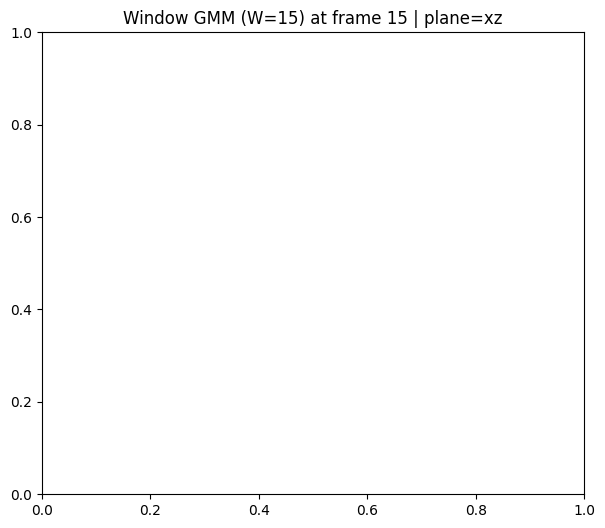

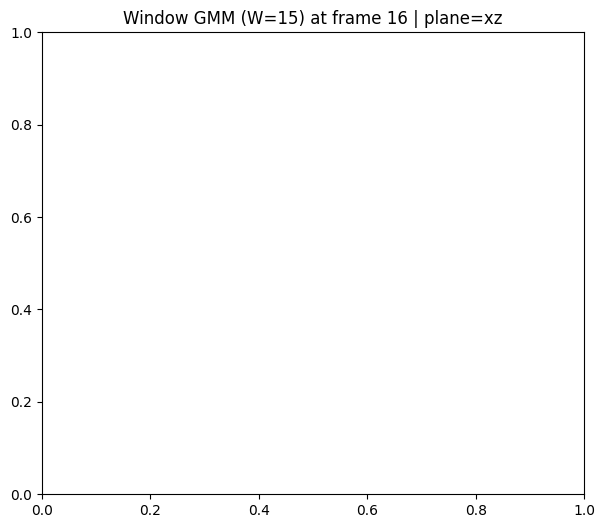

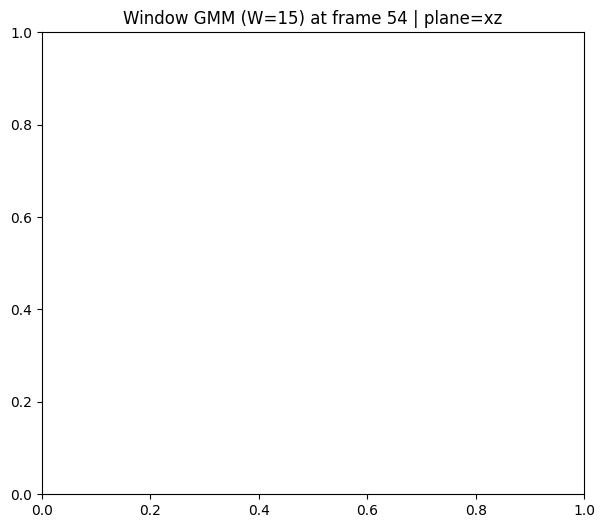

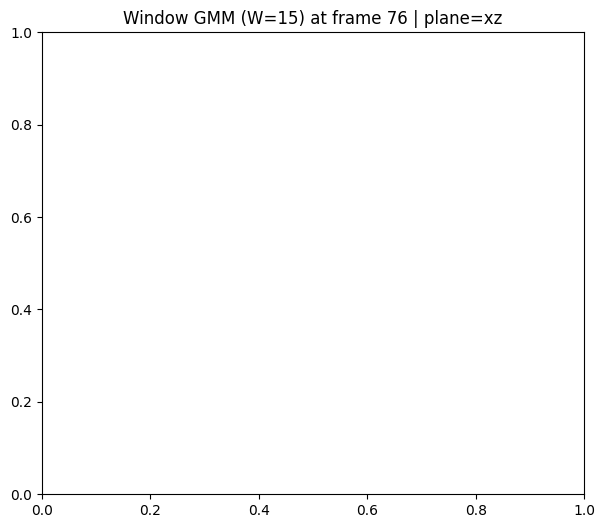

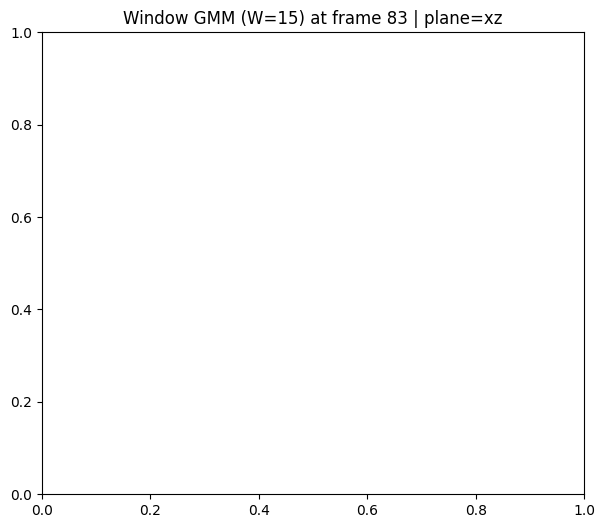

In [34]:
visualize_window_2d(
    input_path=r"E:\0.TA_Teguh\dataset3\B\Jalan2.csv",
    head3_path=r"E:\0.TA_Teguh\GMM\Head 3\B\Jalan2.jsonl",
    plane="xz"   # bisa diganti "yz"
)


CELL 20 — Interactive: 3D scatter per frame (color by p_torso)

In [35]:
def visualize_frame_3d(head1_csv_path: str):
    df = pd.read_csv(head1_csv_path)
    max_frame = int(df["frame"].max())

    def render(frame_id: int):
        fdf = df[df["frame"] == frame_id]
        fig = plt.figure(figsize=(7, 6))
        ax = fig.add_subplot(111, projection="3d")
        ax.set_title(f"Frame {frame_id} | 3D points colored by p_torso")

        if len(fdf) == 0:
            ax.text2D(0.5, 0.5, "No points in this frame (after gating)", transform=ax.transAxes, ha="center")
            plt.show()
            return

        x = fdf["x"].to_numpy()
        y = fdf["y"].to_numpy()
        z = fdf["z"].to_numpy()
        p = fdf["p_torso"].to_numpy()

        sc = ax.scatter(x, y, z, c=p, s=10, alpha=0.8)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        fig.colorbar(sc, ax=ax, fraction=0.03, pad=0.08, label="p_torso")

        # Optional: centroid from points with high p_torso
        mask = p >= 0.7
        if np.any(mask):
            cx, cy, cz = np.mean(x[mask]), np.mean(y[mask]), np.mean(z[mask])
            ax.scatter([cx], [cy], [cz], s=80, marker="X")
            ax.text(cx, cy, cz, "centroid(high p_torso)", fontsize=9)

        plt.show()

    if HAS_WIDGETS:
        slider = widgets.IntSlider(value=1, min=1, max=max_frame, step=1, description="frame")
        out = widgets.interactive_output(render, {"frame_id": slider})
        display(slider, out)
    else:
        print("ipywidgets not available. Call render(frame_id) manually.")
        render(1)


In [37]:
visualize_frame_3d(
    r"E:\0.TA_Teguh\GMM\Head 1\B\Jalan54.csv"
)


IntSlider(value=1, description='frame', max=156, min=1)

Output()